## Importing the relevant libraries

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=12cf44191d67e6368da0397b87379c5da158e09f79bef277d5db7eace1356c3e
  Stored in directory: /root/.cache/pip/wheels/e1/e8/db/ebe4dcd7d7d11208c1e4e4ef246cea4fcc8d463c93405a6555
Successfully built wget


In [2]:
!pip install keras-tuner

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, wget
warnings.filterwarnings('ignore')
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
import tensorflow as tf
import keras_tuner as kt
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score
from tqdm.notebook import tqdm
tqdm.pandas()
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
plt.rcParams['figure.figsize'] = (12,8) # Setting the default figure size

## Loading the dataset

In [5]:
train = pd.read_csv("/kaggle/input/emotion-classification-nlp/emotion-labels-train.csv")
val = pd.read_csv("/kaggle/input/emotion-classification-nlp/emotion-labels-val.csv")
test = pd.read_csv("/kaggle/input/emotion-classification-nlp/emotion-labels-test.csv")
train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [6]:
train.shape, val.shape, test.shape

((3613, 2), (347, 2), (3142, 2))

In [7]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,label
0,I'm so confused by the new American horror sto...,fear
1,as a very depressed and suicidal person seeing...,sadness
2,@jessbr0ughton don't be shy next time! We're a...,joy
3,no offense but could troye start dming people ...,anger
4,@Cassena13 I know if I wasn't an optimist I wo...,sadness


## Data Exploration, Exploratory Data Analysis (EDA) and Feature Engineering

In [8]:
df.shape

(7102, 2)

In [9]:
df.label.value_counts()

fear       2252
anger      1701
joy        1616
sadness    1533
Name: label, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7102 entries, 0 to 7101
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7102 non-null   object
 1   label   7102 non-null   object
dtypes: object(2)
memory usage: 111.1+ KB


In [11]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [12]:
df.duplicated().sum()

0

In [13]:
## Checking for any empty strings within the text column
df.text.str.isspace().sum()

0

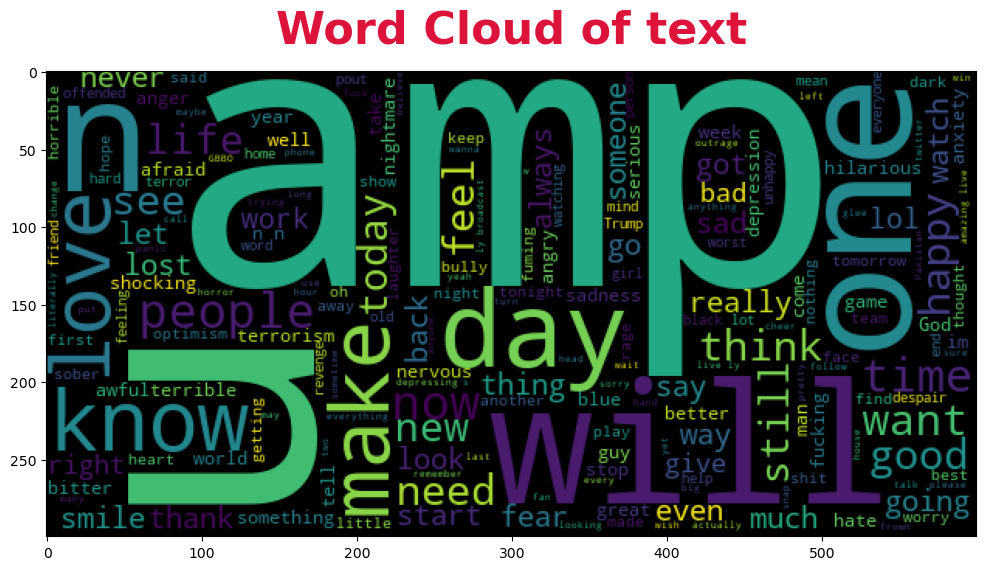

In [14]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.text))
plt.imshow(wc)
plt.title('Word Cloud of text',fontsize=32,fontweight='bold',color='crimson',pad=20);

In [15]:
df['text_len'] = df.text.apply(len)
df.head()

,text,label,text_len
0,I'm so confused by the new American horror sto...,fear,50
1,as a very depressed and suicidal person seeing...,sadness,140
2,@jessbr0ughton don't be shy next time! We're a...,joy,74
3,no offense but could troye start dming people ...,anger,102
4,@Cassena13 I know if I wasn't an optimist I wo...,sadness,58


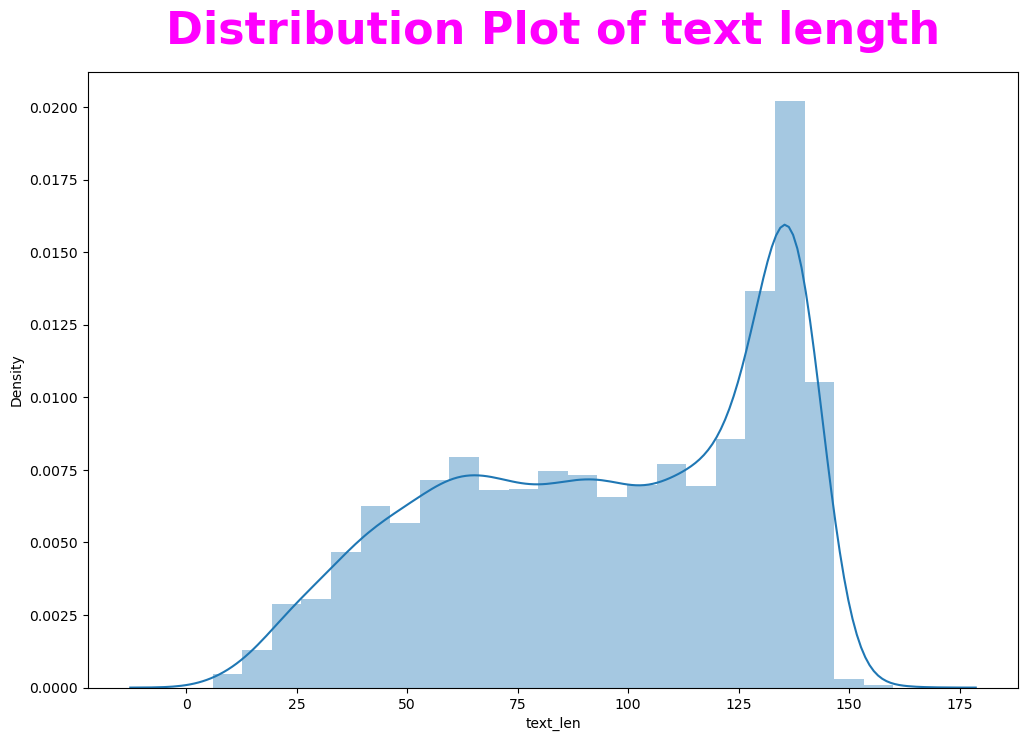

In [16]:
sns.distplot(df.text_len)
plt.title('Distribution Plot of text length',fontsize=32,color='magenta',fontweight='bold',pad=20);

In [17]:
df.describe()

,text_len
count,7102.000000
mean,95.250915
std,36.589539
min,6.000000
25%,65.000000
50%,100.000000
75%,131.000000
max,160.000000


In [18]:
max_text_len = 90 # Setting the max text length to its average value

## Encoding the target labels

In [19]:
labels_dict = {}

for idx, label in enumerate(df.label.unique()):
    labels_dict[label] = idx

labels_dict

{'fear': 0, 'sadness': 1, 'joy': 2, 'anger': 3}

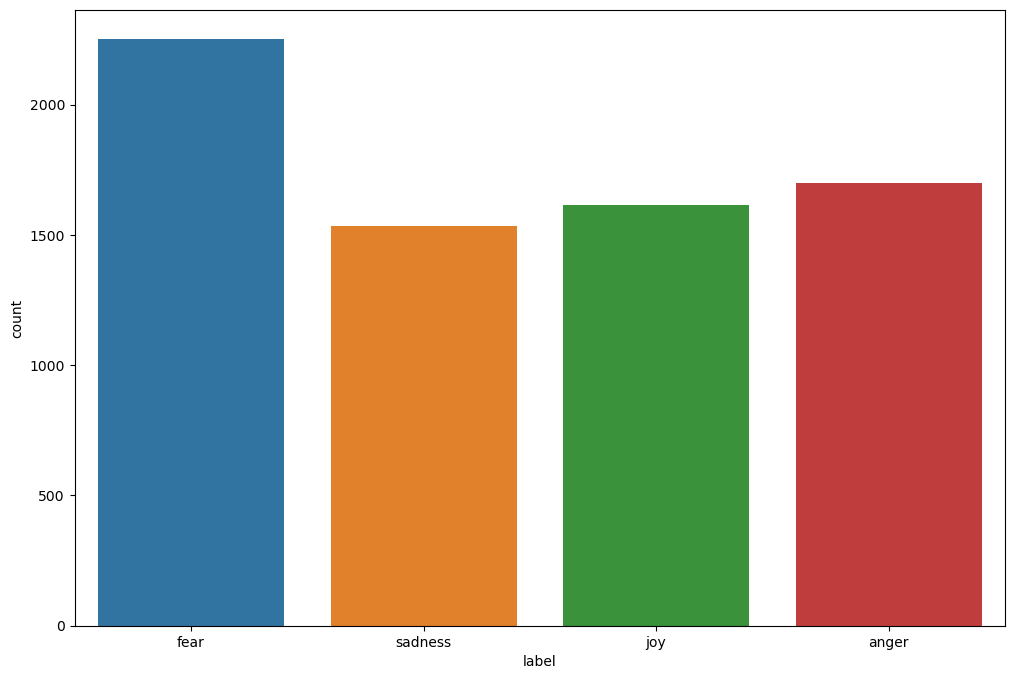

In [20]:
sns.countplot(df,x='label');

There are 4 emotions in total, fear, sadness, joy and anger. As is evident from the above graph, the class "fear" has the highest instances, which is followed by the emotions "anger", "joy" and "sadness" with "sadness" having the least instances.

In [21]:
df.label = df.label.apply(lambda x: labels_dict[x])

## Preprocessing the text data

In [22]:
def text_preprocess(data,col):
    data[col] = data[col].progress_apply(func=clean_html) # Eliminates HTML tags and other HTML syntax
    data[col] = data[col].progress_apply(func=punct) # Removes punctuation characters
    data[col] = data[col].progress_apply(func=remove_) # Removes underspace characters
    data[col] = data[col].progress_apply(func=remove_digits) # Removes digits
    data[col] = data[col].progress_apply(func=remove_links) # Eliminates links and URLs
    data[col] = data[col].progress_apply(func=remove_special_characters) # Removes special characters
    data[col] = data[col].progress_apply(func=removeStopWords) # Removes stopwords
    data[col] = data[col].progress_apply(func=lower) # Converts text to lowercase
    data[col] = data[col].progress_apply(func=non_ascii) # Removes non-ASCII characters
    data[col] = data[col].progress_apply(func=email_address) # Removes email addresses
    return data

In [23]:
preprocessed_df = text_preprocess(df,'text')
preprocessed_df.head()

  0%|          | 0/7102 [00:00<?, ?it/s]

  0%|          | 0/7102 [00:00<?, ?it/s]

  0%|          | 0/7102 [00:00<?, ?it/s]

  0%|          | 0/7102 [00:00<?, ?it/s]

  0%|          | 0/7102 [00:00<?, ?it/s]

  0%|          | 0/7102 [00:00<?, ?it/s]

  0%|          | 0/7102 [00:00<?, ?it/s]

  0%|          | 0/7102 [00:00<?, ?it/s]

  0%|          | 0/7102 [00:00<?, ?it/s]

  0%|          | 0/7102 [00:00<?, ?it/s]

,text,label,text_len
0,confused new american horror story,0,50
1,depressed suicidal person seeing someone sing ...,1,140
2,jessbrughton shy next time we cheery bunch n n...,2,74
3,offense could troye start dming people feel le...,3,102
4,cassena know optimist would despair,1,58


## Downloading the pretrained tokenizer and BERT transformer model from the Hugging Face platform

In [24]:
tokenizer = AutoTokenizer.from_pretrained('LawalAfeez/emotion_detection')
bert_model = TFAutoModelForSequenceClassification.from_pretrained('LawalAfeez/emotion_detection')

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at LawalAfeez/emotion_detection.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


## Splitting the preprecessed dataset into train and test sets

In [25]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.label)

## Performing tokenization of text data

In [26]:
X_train = tokenizer(text=train_df.text.tolist(),
                   add_special_tokens=True,
                   padding="max_length",
                   truncation=False,
                   max_length=max_text_len,
                   return_tensors='tf',
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=1)

X_test = tokenizer(text=test_df.text.tolist(),
                  add_special_tokens=True,
                  padding="max_length",
                  truncation=False,
                  max_length=max_text_len,
                  return_tensors='tf',
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  verbose=1)

## Defining the model architecture

In [27]:
input_ids = Input(shape=(max_text_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_text_len,),dtype=tf.int32,name='attention_mask')

In [28]:
word_embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output

output = Flatten()(word_embeddings)
output = Dense(units=2048,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=1024,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=1024,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=512,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=128,activation='relu')(output)
output = Dense(units=4,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers

In [29]:
# Making the pretrained BERT transformer model layer trainable so that it can be fine-tuned according to our custom dataset
model.layers[2].trainable = True

## Visualizing the model architecture

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 90)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 90)]         0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66958086   ['input_ids[0][0]',              
 assification (TFDistilBertForS  rOutput(loss=None,               'attention_mask[0][0]']         
 equenceClassification)         logits=(None, 6),                                                 
                                 hidden_states=None                                           

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


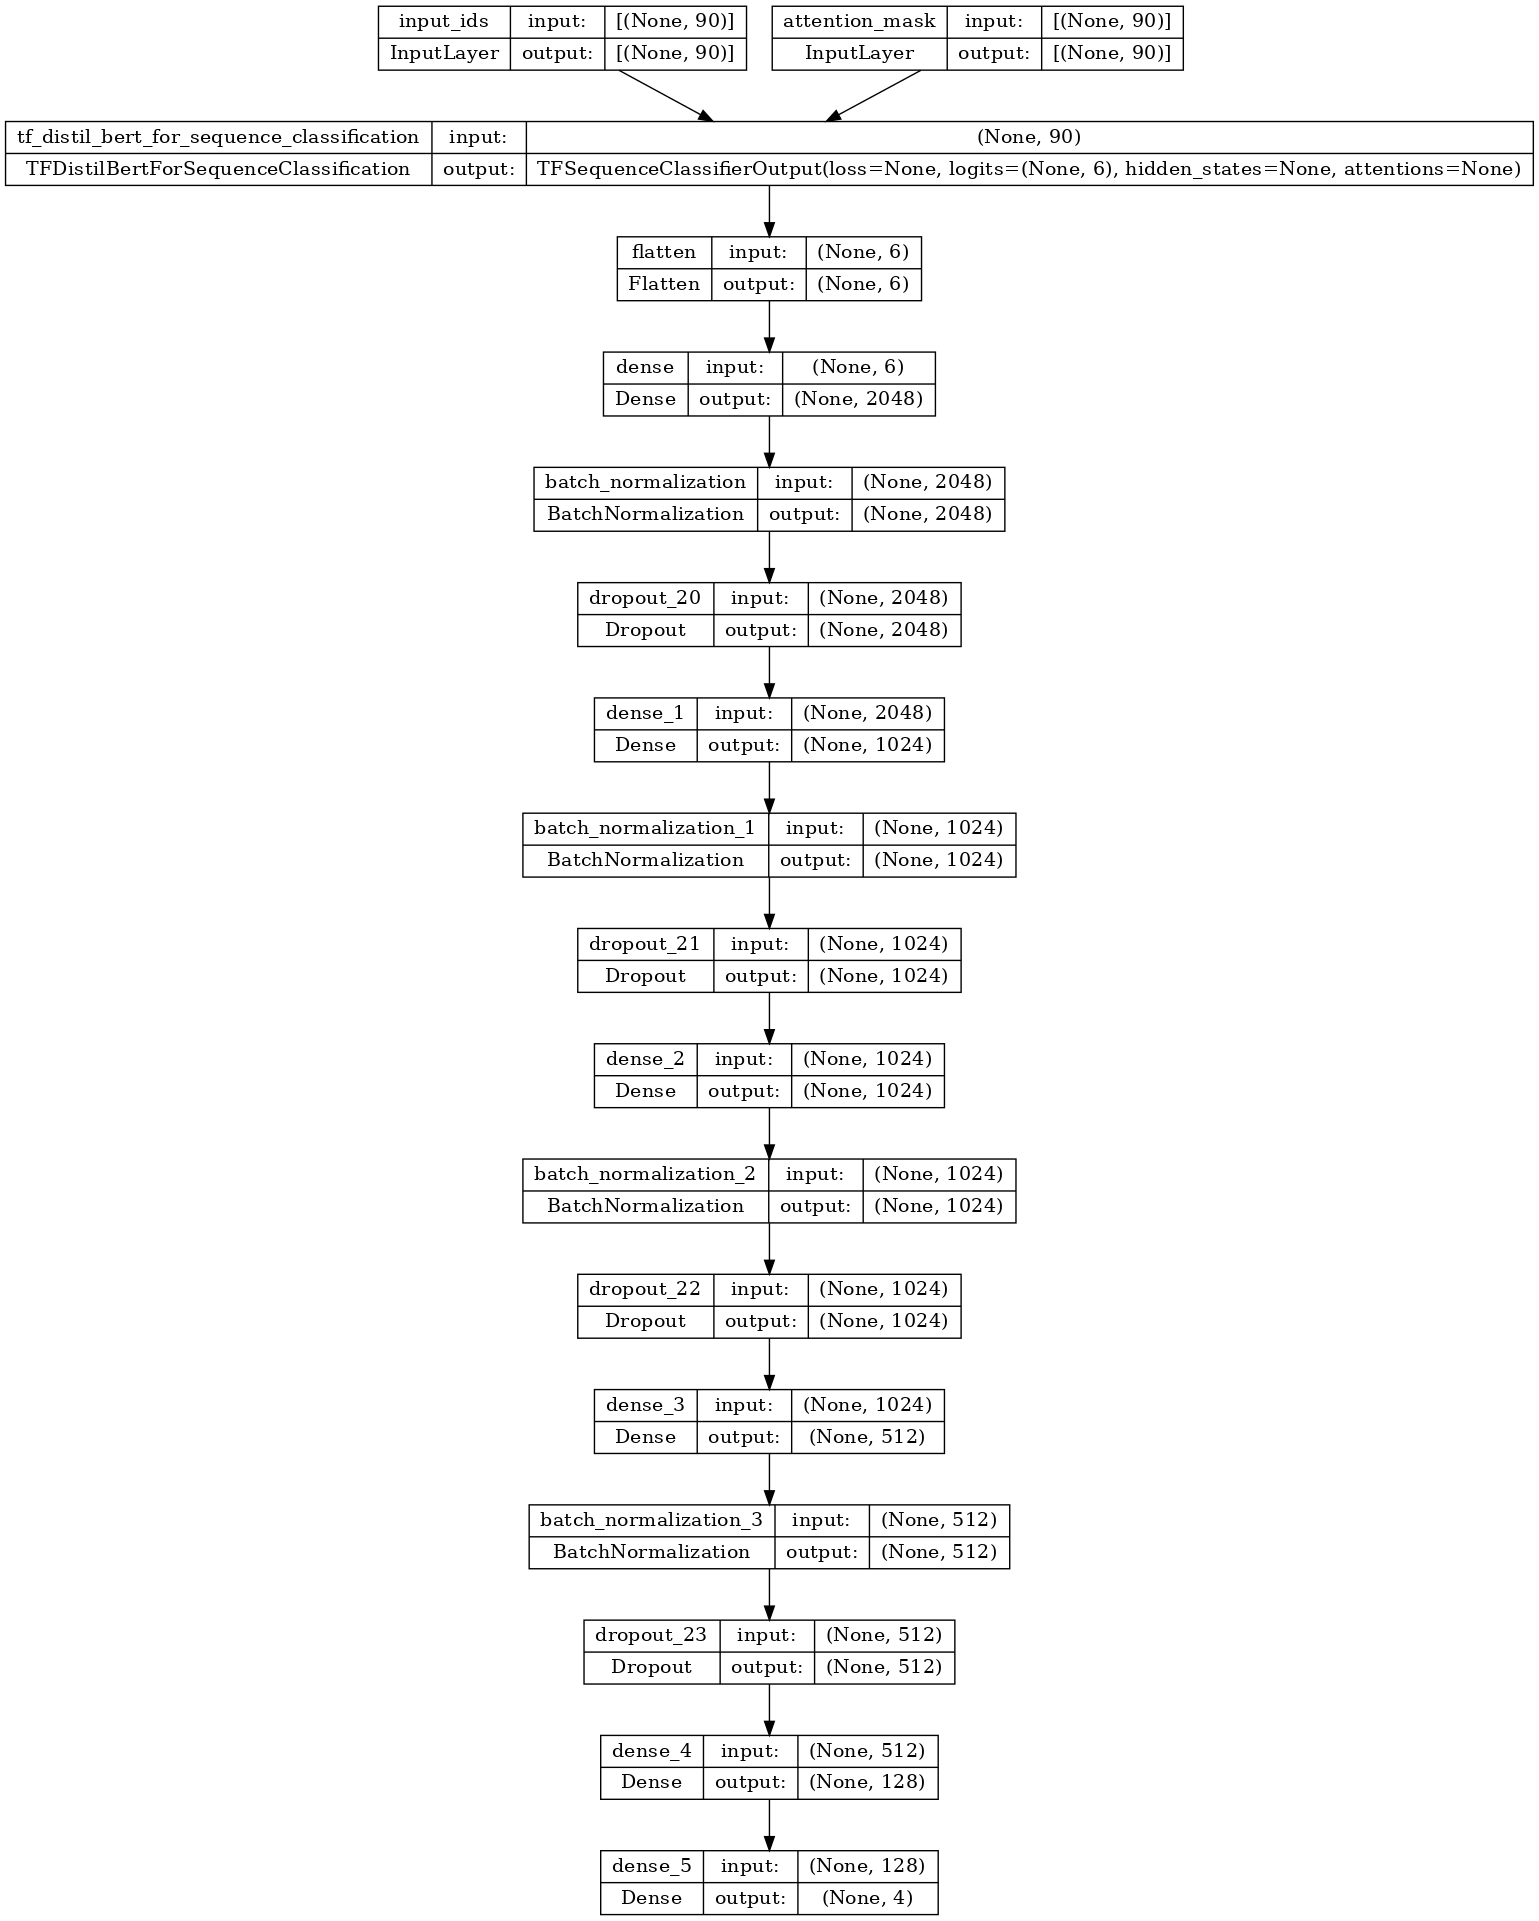

In [31]:
plot_model(model,to_file='fine-tuned_transformer_model.png',dpi=100,show_shapes=True)

## Compiling the model

In [32]:
adam = Adam(learning_rate=5e-5,
           epsilon=2e-8,
           weight_decay=1e-2,
           clipnorm=1.0)

model.compile(loss='categorical_crossentropy',optimizer=adam,metrics='categorical_accuracy')

## Training the fine-tuned BERT transformer model

In [33]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=150,mode='max',verbose=1,restore_best_weights=True,start_from_epoch=50)
mc = ModelCheckpoint('emotion_detector.h5',monitor='val_balanced_accuracy',verbose=1,save_best_only=True,mode='max')

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_df.label),
             epochs=200,
             batch_size=64,
             callbacks=[es,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
             )

Epoch 1/200
78/78 [==============================] - 78s 613ms/step - loss: 1.2234 - categorical_accuracy: 0.5323 - val_loss: 1.2287 - val_categorical_accuracy: 0.5673
Epoch 2/200
78/78 [==============================] - 51s 655ms/step - loss: 0.6405 - categorical_accuracy: 0.7815 - val_loss: 0.9468 - val_categorical_accuracy: 0.6298
Epoch 3/200
78/78 [==============================] - 52s 674ms/step - loss: 0.4334 - categorical_accuracy: 0.8562 - val_loss: 0.7888 - val_categorical_accuracy: 0.8325
Epoch 4/200
78/78 [==============================] - 52s 664ms/step - loss: 0.3059 - categorical_accuracy: 0.8994 - val_loss: 0.5335 - val_categorical_accuracy: 0.8339
Epoch 5/200
78/78 [==============================] - 52s 665ms/step - loss: 0.2345 - categorical_accuracy: 0.9191 - val_loss: 0.4118 - val_categorical_accuracy: 0.8588
Epoch 6/200
78/78 [==============================] - 52s 667ms/step - loss: 0.1673 - categorical_accuracy: 0.9411 - val_loss: 0.4914 - val_categorical_accuracy:

## Visualizing the model performance during training

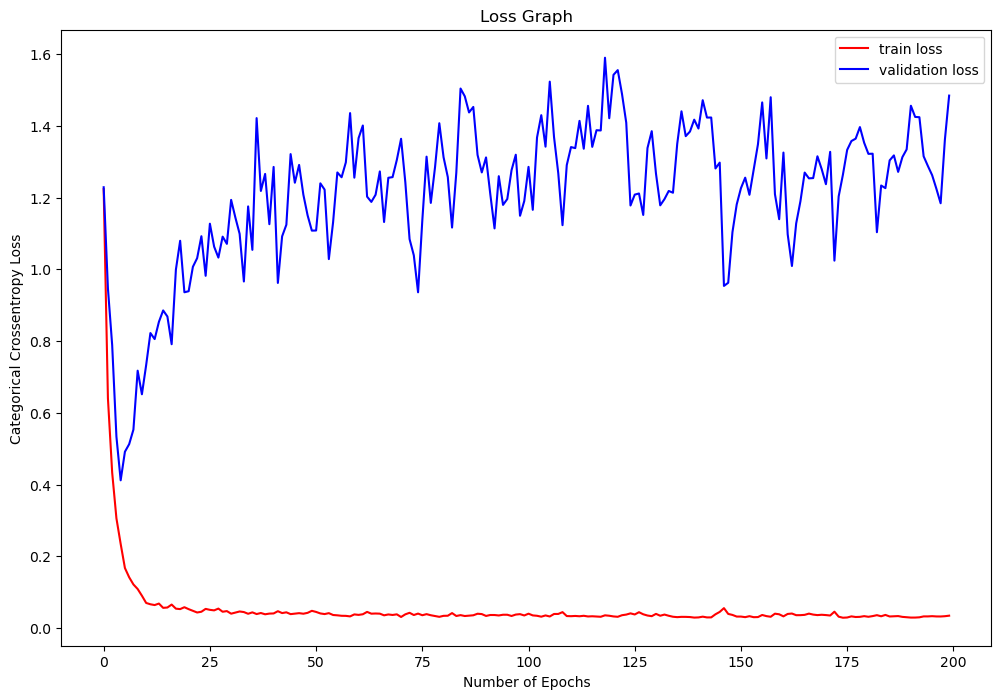

In [34]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

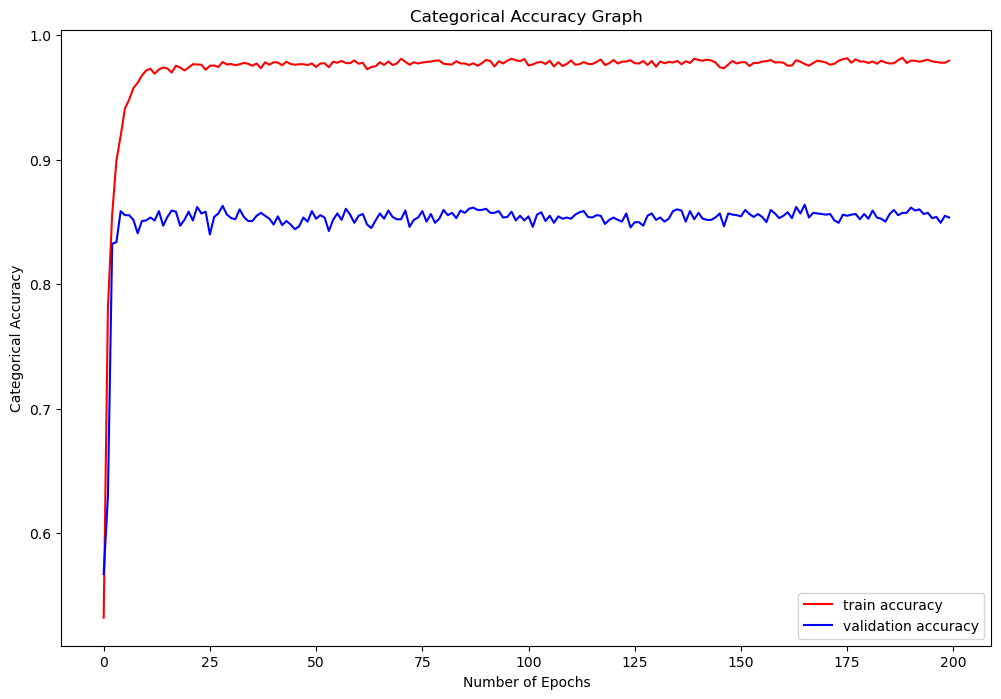

In [35]:
plt.plot(r.history['categorical_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_categorical_accuracy'],'b',label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Categorical Accuracy')
plt.title('Categorical Accuracy Graph')
plt.legend();

## Tuning the hyperparameters of the fine-tuned BERT transformer model

In [36]:
def build_model(hp):
    input_ids = Input(shape=(max_text_len,),dtype=tf.int32,name='input_ids')
    attention_mask = Input(shape=(max_text_len,),dtype=tf.int32,name='attention_mask')
    word_embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
    output = Flatten()(word_embeddings)
    
    for i in range(hp.Int('num_layers',min_value=1,max_value=10)):
        output = Dense(units=hp.Int('units'+str(i),min_value=32,max_value=1024,step=32),
                       activation=hp.Choice("activation",["relu","tanh","sigmoid"]))(output)
        output = BatchNormalization()(output)
        output = Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))(output)
        
    output = Dense(units=4,activation='softmax')(output)
    model = Model(inputs=[input_ids,attention_mask],outputs=output)
    model.layers[2].trainable = True
    optimizer = hp.Choice('optimizer',values=['adam','rmsprop','sgd','adadelta','nadam'])
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics='categorical_accuracy')
    return model

In [37]:
tuner = kt.RandomSearch(build_model,
                        objective=kt.Objective(name='val_categorical_accuracy',direction='max'),
                        project_name='hyperparameter-tuning',
                        directory='my_dir')

In [38]:
tuner.search({'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']}, 
             to_categorical(train_df.label), 
             epochs=50,
             batch_size=64,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, to_categorical(test_df.label)))

Trial 10 Complete [00h 41m 40s]
val_categorical_accuracy: 0.3172219693660736

Best val_categorical_accuracy So Far: 0.8629751205444336
Total elapsed time: 07h 02m 01s


In [39]:
tuner.get_best_hyperparameters()[0].values # Displaying the most optimal hyperparameters

{'num_layers': 6,
 'units0': 640,
 'activation': 'relu',
 'dropout0': 0.3,
 'optimizer': 'sgd',
 'units1': 32,
 'dropout1': 0.1,
 'units2': 32,
 'dropout2': 0.1,
 'units3': 32,
 'dropout3': 0.1,
 'units4': 32,
 'dropout4': 0.1,
 'units5': 32,
 'dropout5': 0.1}

In [40]:
try:
    final_model = tuner.get_best_models(num_models=1)[0] # Fetching the best performing model
    print(final_model)
except Exception as e:
    print(e)

## Evaluating the performance of the fine-tuned DistilBERT transformer model on test data

### Baseline fine-tuned DistilBERT model evaluation

In [41]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
print("Test Sparse Categorical Balanced Crossentropy Loss:",loss)
print("Test Balanced Categorical Accuracy:",acc)

67/67 [==============================] - 8s 100ms/step - loss: 1.1093 - categorical_accuracy: 0.8592
Test Sparse Categorical Balanced Crossentropy Loss: 1.1093335151672363
Test Balanced Categorical Accuracy: 0.8592210412025452


In [42]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Dictionary of encoded labels:",labels_dict)
print("Classification Report:")
print(classification_report(test_df.label,test_predictions))

67/67 [==============================] - 9s 97ms/step
Dictionary of encoded labels: {'fear': 0, 'sadness': 1, 'joy': 2, 'anger': 3}
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       676
           1       0.85      0.81      0.83       460
           2       0.92      0.89      0.90       485
           3       0.90      0.82      0.86       510

    accuracy                           0.86      2131
   macro avg       0.87      0.86      0.86      2131
weighted avg       0.86      0.86      0.86      2131



In [43]:
print("Accuracy Score:",accuracy_score(test_df.label,test_predictions))
print("Micro-Averaged Precision Score:",precision_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged Precision Score:",precision_score(test_df.label,test_predictions,average='macro'))
print("Weighted Precision Score:",precision_score(test_df.label,test_predictions,average='weighted'))
print("Micro-Averaged Recall Score:",recall_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged Recall Score:",recall_score(test_df.label,test_predictions,average='macro'))
print("Weighted Recall Score:",recall_score(test_df.label,test_predictions,average='weighted'))
print("Micro-Averaged F1 Score:",f1_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged F1 Score:",f1_score(test_df.label,test_predictions,average='macro'))
print("Weighted F1 Score:",f1_score(test_df.label,test_predictions,average='weighted'))

Accuracy Score: 0.8592210229938996
Micro-Averaged Precision Score: 0.8592210229938996
Macro-Averaged Precision Score: 0.8679396176468916
Weighted Precision Score: 0.8625664847936705
Micro-Averaged Recall Score: 0.8592210229938996
Macro-Averaged Recall Score: 0.8554711326736939
Weighted Recall Score: 0.8592210229938996
Micro-Averaged F1 Score: 0.8592210229938996
Macro-Averaged F1 Score: 0.8604079281821589
Weighted F1 Score: 0.8594579169032848


### Model evaluation after tuning the hyperparameters of fine-tuned DistilBERT model

In [44]:
loss, acc = final_model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
print("Test Sparse Categorical Balanced Crossentropy Loss:",loss)
print("Test Balanced Categorical Accuracy:",acc)

67/67 [==============================] - 11s 103ms/step - loss: 1.0297 - categorical_accuracy: 0.8630
Test Sparse Categorical Balanced Crossentropy Loss: 1.0297473669052124
Test Balanced Categorical Accuracy: 0.8629751205444336


In [45]:
test_predictions = final_model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Dictionary of encoded labels:",labels_dict)
print("Classification Report:")
print(classification_report(test_df.label,test_predictions))

67/67 [==============================] - 9s 98ms/step
Dictionary of encoded labels: {'fear': 0, 'sadness': 1, 'joy': 2, 'anger': 3}
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       676
           1       0.86      0.81      0.83       460
           2       0.93      0.88      0.91       485
           3       0.89      0.83      0.86       510

    accuracy                           0.86      2131
   macro avg       0.87      0.86      0.86      2131
weighted avg       0.87      0.86      0.86      2131



In [46]:
print("Accuracy Score:",accuracy_score(test_df.label,test_predictions))
print("Micro-Averaged Precision Score:",precision_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged Precision Score:",precision_score(test_df.label,test_predictions,average='macro'))
print("Weighted Precision Score:",precision_score(test_df.label,test_predictions,average='weighted'))
print("Micro-Averaged Recall Score:",recall_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged Recall Score:",recall_score(test_df.label,test_predictions,average='macro'))
print("Weighted Recall Score:",recall_score(test_df.label,test_predictions,average='weighted'))
print("Micro-Averaged F1 Score:",f1_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged F1 Score:",f1_score(test_df.label,test_predictions,average='macro'))
print("Weighted F1 Score:",f1_score(test_df.label,test_predictions,average='weighted'))

Accuracy Score: 0.8629751290473956
Micro-Averaged Precision Score: 0.8629751290473956
Macro-Averaged Precision Score: 0.8722899934191831
Weighted Precision Score: 0.8666208703178802
Micro-Averaged Recall Score: 0.8629751290473956
Macro-Averaged Recall Score: 0.8586897619786459
Weighted Recall Score: 0.8629751290473956
Micro-Averaged F1 Score: 0.8629751290473957
Macro-Averaged F1 Score: 0.864177036204409
Weighted F1 Score: 0.8633345834459296
